# Densenet

In [1]:
import os, sys, math, time, json, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps, ImageEnhance
from torchvision import datasets, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns

# 1. Data Augmentation and Split

In [2]:
batch_size = 32
img_size = 224
epochs = 20
lr = 1e-4
weight_decay = 1e-4
num_workers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = "/kaggle/input/chilli-dataset/Mehedi2"

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val", "test"]
}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

Classes: ['cercospora', 'healthy', 'mites_and_trips', 'nutritional', 'powdery mildew']


# 2. Early Stopping

In [4]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = float('inf')
        self.early_stop = False
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=3, min_delta=1e-4)

# 3. Loading Model

In [5]:
def get_model(num_classes):
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Sequential(
    nn.Dropout(p=0.6),
    nn.Linear(model.classifier.in_features, num_classes)
    )
    return model.to(device)

num_classes = len(class_names)
model = get_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(enabled=(device.type == "cuda"))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 75.5MB/s]
/tmp/ipykernel_19/2192139910.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


# 4. Training and saving the model

In [6]:
train_losses, val_losses, val_f1s = [], [], []
best_f1 = -1.0
best_path = "densenet121_best.pth"
y_true, y_pred = [], []

def run_epoch(loader, model, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    pbar = tqdm(loader, total=len(loader))
    for images, labels in pbar:
        images = images.to(device, non_blocking=True).float()
        labels = torch.as_tensor(labels, device=device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())

    epoch_loss = running_loss / len(loader.dataset)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1 = report['weighted avg']['f1-score']
    return epoch_loss, f1, report

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    tr_loss, tr_f1, _ = run_epoch(dataloaders["train"], model, train=True)
    with torch.no_grad():
        val_loss, val_f1, val_report = run_epoch(dataloaders["val"], model, train=False)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    scheduler.step(val_loss)

    print(f"  train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f} | lr={optimizer.param_groups[0]['lr']:.2e}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), best_path)
        print(f" New best F1: {best_f1:.4f} — saved to {best_path}")

    if early_stopping.step(val_loss):
        print(" Early stopping triggered.")
        break

Epoch 1/20


100%|██████████| 69/69 [00:09<00:00,  7.45it/s]


  train_loss=0.3494 | val_loss=0.0763 | val_f1=0.8993 | lr=1.00e-04
 New best F1: 0.8993 — saved to densenet121_best.pth
Epoch 2/20


100%|██████████| 69/69 [00:05<00:00, 13.52it/s]


  train_loss=0.0724 | val_loss=0.0260 | val_f1=0.9404 | lr=1.00e-04
 New best F1: 0.9404 — saved to densenet121_best.pth
Epoch 3/20


100%|██████████| 69/69 [00:04<00:00, 13.82it/s]


  train_loss=0.0307 | val_loss=0.0195 | val_f1=0.9581 | lr=1.00e-04
 New best F1: 0.9581 — saved to densenet121_best.pth
Epoch 4/20


100%|██████████| 69/69 [00:05<00:00, 12.46it/s]


  train_loss=0.0303 | val_loss=0.0277 | val_f1=0.9664 | lr=1.00e-04
 New best F1: 0.9664 — saved to densenet121_best.pth
Epoch 5/20


100%|██████████| 69/69 [00:05<00:00, 12.60it/s]


  train_loss=0.0238 | val_loss=0.0112 | val_f1=0.9720 | lr=1.00e-04
 New best F1: 0.9720 — saved to densenet121_best.pth
Epoch 6/20


100%|██████████| 69/69 [00:05<00:00, 12.76it/s]


  train_loss=0.0108 | val_loss=0.0200 | val_f1=0.9762 | lr=1.00e-04
 New best F1: 0.9762 — saved to densenet121_best.pth
Epoch 7/20


100%|██████████| 69/69 [00:04<00:00, 14.07it/s]


  train_loss=0.0084 | val_loss=0.0093 | val_f1=0.9793 | lr=1.00e-04
 New best F1: 0.9793 — saved to densenet121_best.pth
Epoch 8/20


100%|██████████| 69/69 [00:04<00:00, 13.89it/s]


  train_loss=0.0180 | val_loss=0.0357 | val_f1=0.9811 | lr=1.00e-04
 New best F1: 0.9811 — saved to densenet121_best.pth
Epoch 9/20


100%|██████████| 69/69 [00:04<00:00, 13.90it/s]


  train_loss=0.0168 | val_loss=0.0242 | val_f1=0.9827 | lr=1.00e-04
 New best F1: 0.9827 — saved to densenet121_best.pth
Epoch 10/20


100%|██████████| 69/69 [00:05<00:00, 12.46it/s]


  train_loss=0.0151 | val_loss=0.0267 | val_f1=0.9840 | lr=1.00e-04
 New best F1: 0.9840 — saved to densenet121_best.pth
 Early stopping triggered.


# 5. Plotting Loss Curve

100%|██████████| 70/70 [00:09<00:00,  7.58it/s]


Test F1: 0.9842034971586714
{
  "0": {
    "precision": 0.9866935785303133,
    "recall": 0.9831291199582883,
    "f1-score": 0.9849081242421416,
    "support": 26851
  },
  "1": {
    "precision": 0.9813171241050119,
    "recall": 0.9868001649979375,
    "f1-score": 0.9840510068619935,
    "support": 26667
  },
  "2": {
    "precision": 0.9833198380566801,
    "recall": 0.9826435246995995,
    "f1-score": 0.982981565048465,
    "support": 24717
  },
  "3": {
    "precision": 0.9780621572212066,
    "recall": 0.975776574522656,
    "f1-score": 0.9769180290450512,
    "support": 17545
  },
  "4": {
    "precision": 0.9921941769699733,
    "recall": 0.992533485323454,
    "f1-score": 0.9923638021426944,
    "support": 17545
  },
  "accuracy": 0.9842047209353629,
  "macro avg": {
    "precision": 0.984317374976637,
    "recall": 0.984176573900387,
    "f1-score": 0.9842445054680692,
    "support": 113325
  },
  "weighted avg": {
    "precision": 0.984207869810342,
    "recall": 0.98420472

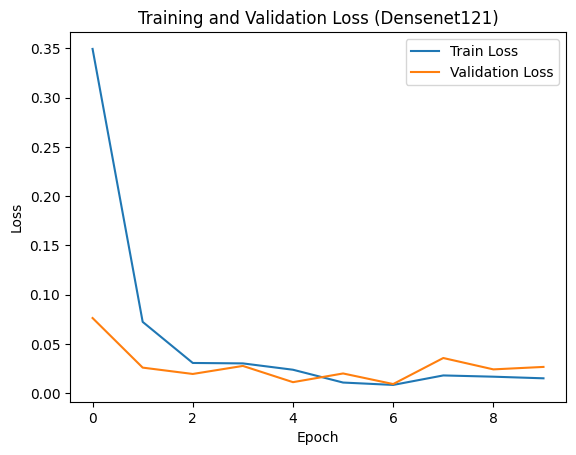

In [7]:
if Path(best_path).exists():
    model.load_state_dict(torch.load(best_path, map_location=device))

with torch.no_grad():
    test_loss, test_f1, test_report = run_epoch(dataloaders["test"], model, train=False)

print("Test F1:", test_f1)
print(json.dumps(test_report, indent=2))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss (Densenet121)")
plt.show()

# 6. Confusion Matrix

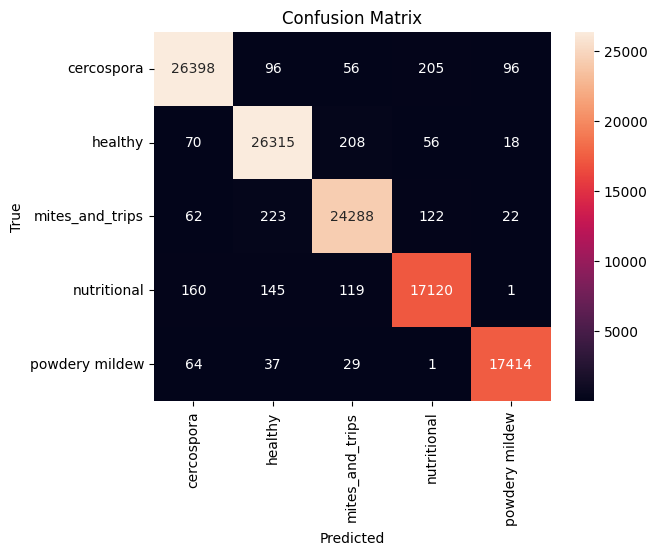

                 precision    recall  f1-score   support

     cercospora       0.99      0.98      0.98     26851
        healthy       0.98      0.99      0.98     26667
mites_and_trips       0.98      0.98      0.98     24717
    nutritional       0.98      0.98      0.98     17545
 powdery mildew       0.99      0.99      0.99     17545

       accuracy                           0.98    113325
      macro avg       0.98      0.98      0.98    113325
   weighted avg       0.98      0.98      0.98    113325



In [8]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))